In [ ]:
import pandas as pd

In [ ]:
df_listing = pd.read_csv("data/Antwerp/data/listings.csv")

In [ ]:
df_listing.info()

### Calculez le nombre d’host et le nombre de review par quartier. (​​neighbourhood_cleansed)?

In [ ]:
nombre_host = df_listing.groupby('neighbourhood_cleansed').host_id.nunique()

In [ ]:
nombre_review = df_listing.groupby('neighbourhood_cleansed').number_of_reviews.sum()

In [157]:
res = pd.concat([nombre_host,nombre_review], axis = 1)
res.info()

<class 'pandas.core.frame.DataFrame'>
Index: 59 entries, Amandus - Atheneum to Zurenborg
Data columns (total 2 columns):
 #   Column             Non-Null Count  Dtype
---  ------             --------------  -----
 0   host_id            59 non-null     int64
 1   number_of_reviews  59 non-null     int64
dtypes: int64(2)
memory usage: 3.4+ KB


# Question 1 : visualization

In [178]:
import matplotlib.pyplot as plt
import numpy

/tmp/ipykernel_277055/3309890034.py:26: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(x,rotation=90)


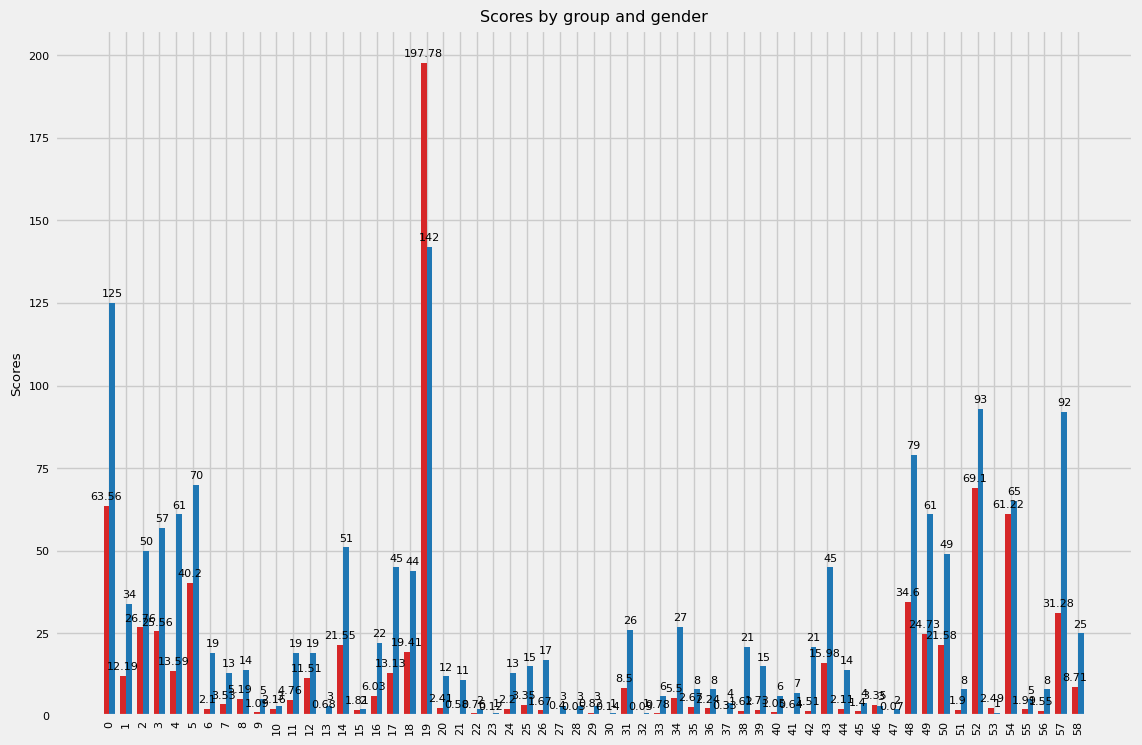

In [189]:
# choice of style
plt.style.use('_mpl-gallery')

# set font size for the plot
plt.rcParams.update({'font.size': 8})
width = 0.35

# set axes data
x = np.arange(len(res.index))

y1 = res["number_of_reviews"]
y2 = res["host_id"]

# create the plot with a given size
fig, ax = plt.subplots(figsize=(11,7))

bar_colors = ['tab:red', 'tab:blue']

rects1 = ax.bar(x-width/2 ,y1/100, width, label='Number of Reviews', color=bar_colors[0])
rects2 = ax.bar(x+width/2 ,y2, width, label='Number of Hosts', color=bar_colors[1])

ax.bar_label(rects1, padding=3)
ax.bar_label(rects2, padding=3)

# rotate the x labels (90 = vertical)
ax.set_xticklabels(x,rotation=90)

ax.set_ylabel('Scores')
ax.set_title('Scores by group and gender')
ax.set_xticks(x)
# ax.legend()

# fig.tight_layout()

plt.show()

### Quels sont les pourcentage d’acceptation et de réponse moyen des hosts?

In [118]:
response_percentage = df_listing["host_response_rate"].dropna().apply(lambda x : x.replace("%","")).astype("int").mean()
response_percentage

94.5228426395939

In [114]:
acceptance_percentage = df_listing["host_acceptance_rate"].dropna().apply(lambda x : x.replace("%","")).astype("int").mean()
acceptance_percentage

85.94274623968947

# Question 2 : visualization

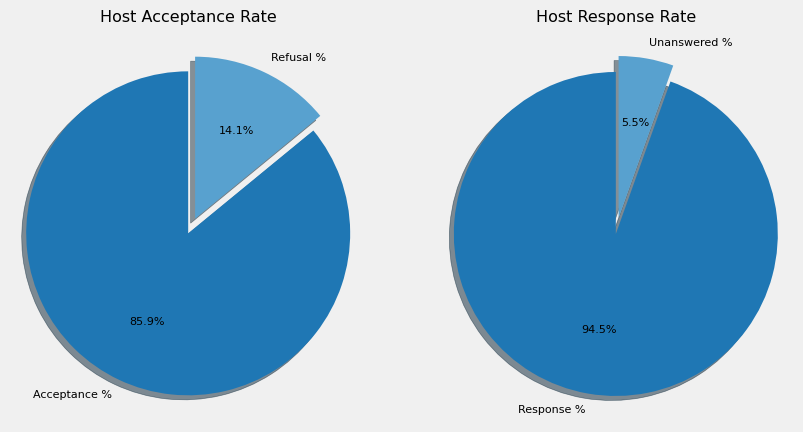

In [146]:
# Pie chart, where the slices will be ordered and plotted counter-clockwise:
labels1 = 'Acceptance %', 'Refusal %'
labels2 = 'Response %', 'Unanswered %'
values1 = [acceptance_percentage,100-acceptance_percentage]
values2 = [response_percentage,100-response_percentage]
explode = (0.1, 0)  # only "explode" the 2nd slice (i.e. 'Hogs')

fig, ax = plt.subplots(1,2,figsize=(8,4))
ax[0].pie(values1, explode=explode, labels=labels1, autopct='%1.1f%%',
        shadow=True, startangle=90)
ax[0].axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
ax[0].set_title('Host Acceptance Rate')

ax[1].pie(values2, explode=explode, labels=labels2, autopct='%1.1f%%',
        shadow=True, startangle=90)
ax[1].axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
ax[1].set_title('Host Response Rate')

plt.show()

### Quel pourcentage des hosts on une vérification:

- par téléphone
- par email
- par email pro

In [ ]:
verification_dict = {}
for i in df_listing[df_listing["host_verifications"].notnull()]["host_verifications"].apply(eval):
    for j in i:
        if j not in verification_dict:
            verification_dict[j] = 1
        else:
            verification_dict[j] += 1

for key in verification_dict.keys():
    verification_dict[key] =  verification_dict[key] / df_listing.shape[0] 

verification_dict



### En fonction du type de room, calculez le nombre moyen d’amenities et l'écart type.

In [ ]:
df_listing["nb_amenities"] = df_listing["amenities"].apply(eval).apply(len)

In [ ]:
df_listing[["nb_amenities","room_type"]].groupby("room_type").agg(["mean","std"])

In [ ]:
df_room_type = df_listing[["nb_amenities","room_type"]].groupby("room_type").agg(["mean","std"])
df_room_type.columns = ["nb_aminities_mean","nb_aminities_std"]
df_room_type

### Quel est le prix median par type de room, le maximum, le minimum, le premier et le troisième quartile?

In [ ]:
df_listing["clean_price"] = df_listing["price"].apply(lambda x: x.replace("$","")) \
                                               .apply(lambda x: x.replace(",","")) \
                                               .astype("float")
           

In [ ]:
df_listing[["clean_price","room_type"]].groupby("room_type").agg(
    median_price=('clean_price', 'median'), 
    max_price=('clean_price', 'max'),
    min_price=('clean_price', 'min'),
    first_quartile_price=('clean_price',lambda x:x.quantile(0.25)),
    third_quartile_price=('clean_price', lambda x:x.quantile(0.75)),
    )

### Si on considère qu’un "bath" vaut 1,  qu’une bath shared vaut 0.5 et qu’un private bath vaut 2. Combien y-a-t-il d’annonces par valeur de salle de bain. (0.5 / 1 / 1.5 ….)?

In [ ]:
def valeur_salle_de_bain(x):
    x_list = x.split(" ")
    x_value = 1
    mapper = {"bath":1, "baths":1, "private":2, "shared":0.5, "half-bath":0.5}
    for element in x_list:
        try: 
            x_value *= float(element)
        except:
            x_value *= mapper[element.lower()]
    return x_value

valeur_salle_de_bain("1.5 shared baths")

In [ ]:
df_listing["bathrooms_text"].dropna().apply(valeur_salle_de_bain).value_counts().sort_index(ascending=True)

In [ ]:
df_listing.info()

In [ ]:
df_listing[["bathrooms","bathrooms_text"]]

### Il y a t’il une corrélation entre le nombre de reviews et la taille de la description en terme de nombre de caractères?

In [ ]:
df_cor = df_listing[["description", "number_of_reviews"]].dropna()
df_cor["description_len"] = df_cor["description"].apply(len) 
df_cor[["description_len", "number_of_reviews"]].corr()

### On suspecte des faux commentaires. Pour identifier cela on regarde les séjours où le nom de l’host est le même que le nom du reviewer.  Quel est ce pourcentage général de séjour où le nom de l'host est identique au nom du reviewer?

In [ ]:
df_reviews = pd.read_csv("Data/reviews.csv")

In [ ]:
df_merge = df_reviews.merge(df_listing, how="left", left_on="listing_id", right_on="id")

In [ ]:
df_merge.loc[ df_merge["host_name"].apply(lambda x:x.lower())== df_merge["reviewer_name"].apply(lambda x:x.lower()), ["host_name","reviewer_name"]]

In [ ]:
171/df_merge.shape[0]